# CMPE 297 Tune resNet50, pretained on imagenet with Alzheimers images, then use it for classification in tensorflow
## Team Equality - Abhishek Bais, Haley Feng, Princy Joy, Shannon Phu    


# 1.0 Initial setup

In [1]:
import tensorflow as tf
print(tf.__version__)

2.6.0


In [3]:
!nvidia-smi

Sun Nov  7 22:34:56 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# 2.0 Setup weights and bias

In [2]:
# Install wandb for experiment tracking
!pip install --upgrade https://github.com/wandb/client/archive/feature/code-save.zip

  Using cached https://github.com/wandb/client/archive/feature/code-save.zip


In [4]:
# Installing wandb library for experiment tracking and hyper parameter optimization
!pip install -q wandb

# Importing wand for logging and hyper-parameter tuning
import wandb
wandb.login()

True

# 3.0 Import libraries

In [48]:
# Imports
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import matplotlib.pyplot as plt
from imutils import paths
from tqdm import tqdm
import tensorflow as tf
import seaborn as sns
import numpy as np
import cv2

# Random seed fixation
tf.random.set_seed(666)
np.random.seed(666)

# 4.0 Load the alzeimer's images
[Dataset](https://www.kaggle.com/tourist55/alzheimers-dataset-4-class-of-images)  


In [54]:
! pip install kaggle
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [55]:
#! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Get alzeimer's dataset
! kaggle datasets download -d tourist55/alzheimers-dataset-4-class-of-images

In [ ]:
! unzip alzheimers-dataset-4-class-of-images.zip

In [56]:
# How many training images for Alzeimers?
train_images = list(paths.list_images("Alzheimer_s Dataset/train"))
print(len(train_images))

5121


In [57]:
# How many training images for Alzeimers?
test_images = list(paths.list_images("Alzheimer_s Dataset/test"))
print(len(test_images))

1279


# 5.0 Inspect random train, test images

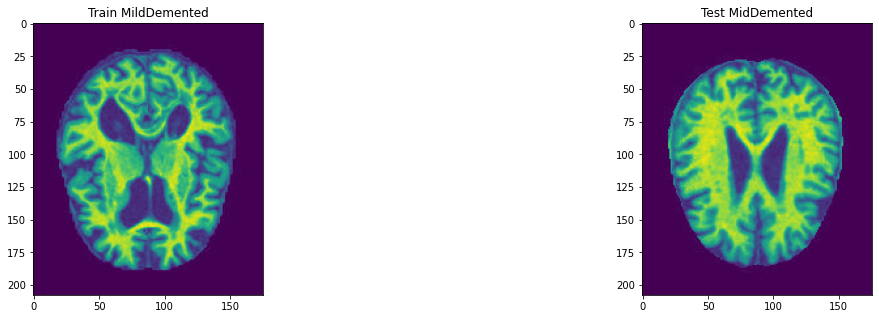

In [58]:
from PIL import Image
import matplotlib.pyplot as plt
f, axarr = plt.subplots(1,2, figsize=(20,5)) 

train_sample = 'mildDem417.jpg'
trainpath = '/content/Alzheimer_s Dataset/train/MildDemented/'
axarr[0].imshow(Image.open(trainpath+train_sample))
axarr[0].set(title = "Train MildDemented")

test_sample = "32.jpg"
testpath = "/content/Alzheimer_s Dataset//test/MildDemented/"
axarr[1].imshow(Image.open(testpath+test_sample))
axarr[1].set(title = "Test MidDemented")

plt.show()

# 6.0 Create training and test split on Alzeimers dataset

In [59]:
# Populate the 4 different classes of train, test Alzeimer's images
train_images_MildDemented = list(paths.list_images("Alzheimer_s Dataset/train/MildDemented"))
train_images_NonDemented = list(paths.list_images("Alzheimer_s Dataset/train/NonDemented"))
train_images_ModerateDemented = list(paths.list_images("Alzheimer_s Dataset/train/ModerateDemented"))
train_images_VeryMildDemented = list(paths.list_images("Alzheimer_s Dataset/train/VeryMildDemented"))

test_images_MildDemented = list(paths.list_images("Alzheimer_s Dataset/test/MildDemented"))
test_images_NonDemented = list(paths.list_images("Alzheimer_s Dataset/test/NonDemented"))
test_images_ModerateDemented = list(paths.list_images("Alzheimer_s Dataset/test/ModerateDemented"))
test_images_VeryMildDemented = list(paths.list_images("Alzheimer_s Dataset/test/VeryMildDemented"))

In [60]:
train_images = train_images_MildDemented + train_images_NonDemented + train_images_ModerateDemented + train_images_VeryMildDemented
test_images = test_images_MildDemented + test_images_NonDemented + test_images_ModerateDemented + test_images_VeryMildDemented

In [61]:
def prepare_images(image_paths, label):
    images = []
    labels = []

    for image in tqdm(image_paths):
        image_pixels = plt.imread(image)
        image_pixels = cv2.resize(image_pixels, (224, 224))
        image_pixels = image_pixels/255.
        images.append(image_pixels)
        labels.append(label)
    images = np.array(images)
    labels = np.array(labels)

    print(images.shape, labels.shape)

    return images, labels

In [62]:
# Training data
X_train_mild, y_train_mild = prepare_images(train_images_MildDemented, "MildDemented")
X_train_non, y_train_non = prepare_images(train_images_NonDemented, "NonDemented")
X_train_moderate, y_train_moderate = prepare_images(train_images_ModerateDemented, "ModerateDemented")
X_train_verymild, y_train_verymild = prepare_images(train_images_VeryMildDemented, "VeryMildDemented")

# Test data
X_test_mild, y_test_mild = prepare_images(test_images_MildDemented, "MildDemented")
X_test_non, y_test_non = prepare_images(test_images_NonDemented, "NonDemented")
X_test_moderate, y_test_moderate = prepare_images(test_images_ModerateDemented, "ModerateDemented")
X_test_verymild, y_test_verymild = prepare_images(test_images_VeryMildDemented, "VeryMildDemented")

100%|██████████| 717/717 [00:00<00:00, 1336.82it/s]


(717, 224, 224) (717,)


100%|██████████| 2560/2560 [00:02<00:00, 1178.62it/s]


(2560, 224, 224) (2560,)


100%|██████████| 52/52 [00:00<00:00, 1271.68it/s]


(52, 224, 224) (52,)


100%|██████████| 1792/1792 [00:01<00:00, 1377.98it/s]


(1792, 224, 224) (1792,)


100%|██████████| 179/179 [00:00<00:00, 1425.55it/s]


(179, 224, 224) (179,)


100%|██████████| 640/640 [00:00<00:00, 1400.97it/s]


(640, 224, 224) (640,)


100%|██████████| 12/12 [00:00<00:00, 922.26it/s]


(12, 224, 224) (12,)


100%|██████████| 448/448 [00:00<00:00, 1357.94it/s]


(448, 224, 224) (448,)


In [63]:
# Prepare concatenated training and test datasets
X_train = np.concatenate((X_train_mild, X_train_non, X_train_moderate, X_train_verymild), axis=0)
y_train = np.concatenate((y_train_mild, y_train_non, y_train_moderate, y_train_verymild), axis=0)

X_test = np.concatenate((X_test_mild, X_test_non, X_test_moderate, X_test_verymild), axis=0)
y_test = np.concatenate((y_test_mild, y_test_non, y_test_moderate, y_test_verymild), axis=0)

In [64]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(5121, 224, 224)
(5121,)
(1279, 224, 224)
(1279,)


In [65]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

 # 7.0 Build the DNN model using resNet50, linear classification projection head

In [66]:
# Image preprocessing utils
@tf.function
def parse_images(image_path):
    image_string = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, size=[224, 224])

    return image

In [67]:
# Create TensorFlow dataset
BATCH_SIZE = 64

train_ds = tf.data.Dataset.from_tensor_slices(train_images)
train_ds = (
    train_ds
    .map(parse_images, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .shuffle(1024)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

In [68]:
# Architecture utils
def get_resnet_simclr(hidden_1, hidden_2, hidden_3):
    base_model = tf.keras.applications.ResNet50(include_top=False, weights=None, input_shape=(224, 224, 3))
    base_model.trainable = True
    inputs = Input((224, 224, 3))
    h = base_model(inputs, training=True)
    h = GlobalAveragePooling2D()(h)

    projection_1 = Dense(hidden_1)(h)
    projection_1 = Activation("relu")(projection_1)
    projection_2 = Dense(hidden_2)(projection_1)
    projection_2 = Activation("relu")(projection_2)
    projection_3 = Dense(hidden_3)(projection_2)

    resnet_simclr = Model(inputs, projection_3)

    return resnet_simclr

In [69]:
wandb.init(project="alzeimers_simclr")

wandb: Wandb version 0.12.6 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


W&B Run: https://app.wandb.ai/abais/alzeimers_simclr/runs/2d1wwfam

# 8.0 Restore w&b weights from pretrained imagenet

In [70]:
simclr_weights = wandb.restore('resnet_simclr.h5', run_path="abais/alzeimers_simclr/runs/1ofby58g")

## 8.1 Apply the weights from previously trained resnet_simclr

In [71]:
resnet_simclr = get_resnet_simclr(256, 128, 50)
resnet_simclr.load_weights(simclr_weights.name)
resnet_simclr.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
activation_1 (Activation)    (None, 128)               0     

#9.0 Visualization helpers for loss, acccuracy

## 9.1. Plot training loss, accuracy

In [72]:
def plot_training(H):
	with plt.xkcd():
		plt.plot(H.history["loss"], label="train_loss")
		plt.plot(H.history["val_loss"], label="val_loss")
		plt.plot(H.history["accuracy"], label="train_acc")
		plt.plot(H.history["val_accuracy"], label="val_acc")
		plt.title("Training Loss and Accuracy")
		plt.xlabel("Epoch #")
		plt.ylabel("Loss/Accuracy")
		plt.legend(loc="lower left")
		plt.show()

# 10.0 Evaluate model with non-linear projection on Alzeimers dataset

In [73]:
def get_linear_model(features):
    linear_model = Sequential([Dense(4, input_shape=(features, ), activation="softmax")])
    return linear_model

In [74]:
resnet_simclr.layers[1].trainable = False
resnet_simclr.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
activation_1 (Activation)    (None, 128)               0     

## 10.1 Evaluate simclr with non-linear projections

In [75]:
# Encoder model with non-linear projections
projection = Model(resnet_simclr.input, resnet_simclr.layers[-2].output)

# Extract train and test features
train_features = projection.predict(X_train)
test_features = projection.predict(X_test)

print(train_features.shape, test_features.shape)

ValueError: ignored

In [ ]:
# Early Stopping to prevent overfitting
es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, verbose=2, restore_best_weights=True)

In [ ]:
# Linear model
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")
linear_model = get_linear_model(128)
linear_model.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"],
                     optimizer="adam")
history = linear_model.fit(train_features, y_train_enc,
                 validation_data=(test_features, y_test_enc),
                 batch_size=64,
                 epochs=1000,
                 callbacks=[tensorboard_callback])
plot_training(history)

## 10.2 Tensorboard visualizations

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs

## 10.3 Tuning on Alzeimer's dataset tensorboard evaluation capture

# 11.0 Visualization helpers for TSNE

In [ ]:
# Visualization of the representations
def plot_vecs_n_labels(v, labels):
    fig = plt.figure(figsize = (10, 10))
    sns.set_style("darkgrid")
    sns.scatterplot(v[:,0], v[:,1], hue=labels, legend='full', palette=sns.color_palette("bright", 5))
    plt.show()

    return fig

## 11.1 TSNE visualization with non-linear projections

In [ ]:
# Representations with the last ReLU
tsne = TSNE()
projection = Model(resnet_simclr.input, resnet_simclr.layers[-2].output)
train_features = projection.predict(X_train)
low_vectors = tsne.fit_transform(train_features)
fig = plot_vecs_n_labels(low_vectors, y_train_enc)